In [31]:
from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision.models import resnet50
from torchvision.transforms import Compose, Normalize, ToTensor
import cv2
import os
import numpy as np
import torch
from matplotlib import pyplot as plt







In [135]:
model = resnet50(pretrained=True)
target_layers = [model.layer4[-1]]

def preprocess_image(img: np.ndarray, mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) -> torch.Tensor:
    preprocessing = Compose([
        ToTensor(),
        Normalize(mean=mean, std=std)
    ])
    return preprocessing(img.copy()).unsqueeze(0)

def img_transform(img,isTensor=False):
    if not isTensor:
        rgb_img = cv2.imread(os.path.join(os.getcwd(),img), 1)[:, :, ::-1]
        print(rgb_img.shape)
        rgb_img = cv2.resize(rgb_img, (224, 224))
        rgb_img = np.float32(rgb_img) / 255
    else:
        #img=img.permute(1,2,0)
        print(img.shape)
        rgb_img = cv2.resize(np.array(img), (224, 224))
        rgb_img = np.float32(np.array(img)) / 255
    print("Done",rgb_img.shape)
    return rgb_img




In [90]:
def heatmap(img,model,target_layers,target_category,cuda=False,isTensor=False):
    input_tensor=[]
    for img_name in img:
        input_tensor.append(preprocess_image(img_transform(img_name,isTensor), mean=[0.5, 0.5, 0.5],std=[0.5, 0.5, 0.5]))
    input_tensor=torch.cat(input_tensor, dim=0)    
    grayscale_cam=[]
    for layer in target_layers:
        cam= GradCAM(model=model, target_layers=[layer], use_cuda=False)
        #np.append(grayscale_cam,cam(input_tensor=input_tensor, target_category=target_category),0)
        #grayscale_cam = cam(input_tensor=input_tensor, target_category=target_category)
        grayscale_cam.append(cam(input_tensor=input_tensor, target_category=target_category))
    #return np.array(grayscale_cam)
    return grayscale_cam


In [91]:
def show_cam_with_image(img,cam_output,use_rgb=True):
    visualization = show_cam_on_image(img_transform(img), cam_output, use_rgb=use_rgb)
    plt.imshow(visualization, interpolation='nearest')
    plt.show()
    return visualization
    

In [117]:
#Usage example
target_category=282
input_img=['test2.jpg']
target_layers = [model.layer4[-1],model.layer3[-1]]
h=heatmap(input_img,model,target_layers,target_category)
hh=heatmap(input_img,model,target_layers,target_category)[0][0]
#v=show_cam_with_image(input_img[0],np.array(hh))

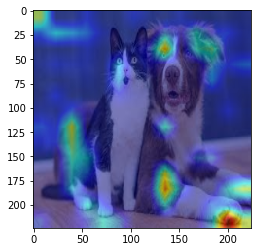

In [118]:
hh=heatmap(input_img,model,target_layers,target_category)[1][0]
v=show_cam_with_image(input_img[0],np.array(hh))

Exception ignored in: <function BaseCAM.__del__ at 0x0000017D11B1EEE0>
Traceback (most recent call last):
  File "D:\Gautam\IIT KGP\1st Sem\Scalable Data Mining\TERM PROJECT\pytorch_grad_cam\base_cam.py", line 192, in __del__
    self.activations_and_grads.release()
AttributeError: 'GradCAM' object has no attribute 'activations_and_grads'


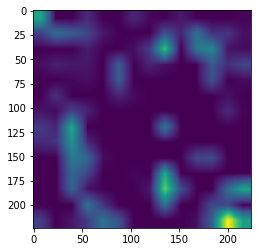

In [119]:
plt.imshow(hh, interpolation='nearest')
plt.show()

In [147]:
img=[torch.randn(3,32,32).permute(1,2,0)]

print(img[0].shape)
hh=heatmap(img,model, [model.layer4[-1]],282,cuda=False,isTensor=True)
img=['test1.jpg']
#hh=heatmap(img,model, [model.layer4[-1]],282,cuda=False,isTensor=False)

torch.Size([32, 32, 3])
torch.Size([32, 32, 3])
Done (32, 32, 3)


In [102]:
def Grad_cam_loss(img,teacher,student,teacher_target_layers,student_target_layers,target_category,cuda=False,isTensor=False):
    total_loss=0    
    assert(len(teacher_target_layers)==len(student_target_layers)), 'Number of student model and teacher model target layers must be same.' 
    t_hm=heatmap(img,teacher,teacher_target_layers,target_category,cuda=cuda,isTensor=isTensor)
    s_hm=heatmap(img,student,student_target_layers,target_category,cuda=cuda,isTensor=isTensor)
    for idx in range(len(teacher_target_layers)):
        for img_idx in range(len(img)):
            t_layer_hm=t_hm[idx][img_idx]
            s_layer_hm=s_hm[idx][img_idx]
            total_loss+=sum(abs(sum(t_layer_hm-s_layer_hm)))        
    return total_loss